In [1]:
import argparse
import ast
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import json

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [ ]:
# set up the parser
parser = argparse.ArgumentParser(description="Train MLP model")
parser.add_argument(
    "--cell_type",
    type=str,
    default="cell_type",
    help="cell type to train model on",
)
parser.add_argument(
    "--control_name",
    type=str,
    default="control_name",
    help="control name to train model on",
)
parser.add_argument(
    "--treatment_name",
    type=str,
    default="treatment_name",
    help="treatment name to train model on",
)
parser.add_argument(
    "--shuffle",
    type=str,
    default="False",
    help="shuffle data before training",
)

# parse the arguments
args = parser.parse_args()
CELL_TYPE = args.cell_type
CONTROL_NAME = args.control_name
TREATMENT_NAME = args.treatment_name
SHUFFLE = ast.literal_eval(args.shuffle)
print(
    f"CELL_TYPE: {CELL_TYPE}",
    f"CONTROL_NAME: {CONTROL_NAME}",
    f"TREATMENT_NAME: {TREATMENT_NAME}",
    f"SHUFFLE: {SHUFFLE}",
    sep="\n",
)
print(SHUFFLE)

In [ ]:
MODEL_NAME = CONTROL_NAME + "_vs_" + TREATMENT_NAME

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/binary_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [6]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'Thapsigargin_1.000_DMSO_0.025']
The dimensions of the data are: (363586, 1270)


Number of total missing values across all columns: 727172
Data Subset Is Off


In [7]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['J06' 'K07']
Wells to use for training, validation, and testing ['B06' 'C06' 'B07' 'C07' 'D06' 'D07' 'I06' 'I07' 'K06' 'J07']


In [8]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [9]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [10]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=mlp_params.TRAIN_PROPORTION_SPLIT,
    val_proportion=mlp_params.VALIDATION_PROPORTION_SPLIT,
    test_proportion=mlp_params.TEST_PROPORTION_SPLIT,
    # train_proportion=0.8,
    # val_proportion=0.1,
    # test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [11]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [12]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1245
Number of out features:  2
Binary_Classification


In [13]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [14]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam


Epoch 0: Validation loss decreased (inf --> 0.495077).  Saving model ...
	 Train_Loss: 0.5698 Train_Acc: 69.878 Val_Loss: 0.4951  BEST VAL Loss: 0.4951  Val_Acc: 74.996



Epoch 1: Validation loss decreased (0.495077 --> 0.473546).  Saving model ...
	 Train_Loss: 0.5333 Train_Acc: 74.874 Val_Loss: 0.4735  BEST VAL Loss: 0.4735  Val_Acc: 77.848



Epoch 2: Validation loss decreased (0.473546 --> 0.454886).  Saving model ...
	 Train_Loss: 0.5102 Train_Acc: 77.079 Val_Loss: 0.4549  BEST VAL Loss: 0.4549  Val_Acc: 80.269



Epoch 3: Validation loss decreased (0.454886 --> 0.442686).  Saving model ...
	 Train_Loss: 0.4923 Train_Acc: 78.744 Val_Loss: 0.4427  BEST VAL Loss: 0.4427  Val_Acc: 80.615



Epoch 4: Validation loss decreased (0.442686 --> 0.430447).  Saving model ...
	 Train_Loss: 0.4780 Train_Acc: 79.684 Val_Loss: 0.4304  BEST VAL Loss: 0.4304  Val_Acc: 82.384



Epoch 5: Validation loss decreased (0.430447 --> 0.420581).  Saving model ...
	 Train_Loss: 0.4664 Train_Acc: 80.524 Val_Loss: 0.4206  BEST VAL Loss: 0.4206  Val_Acc: 82.801



Epoch 6: Validation loss decreased (0.420581 --> 0.413085).  Saving model ...
	 Train_Loss: 0.4569 Train_Acc: 80.890 Val_Loss: 0.4131  BEST VAL Loss: 0.4131  Val_Acc: 82.906



Epoch 7: Validation loss decreased (0.413085 --> 0.406533).  Saving model ...
	 Train_Loss: 0.4494 Train_Acc: 81.098 Val_Loss: 0.4065  BEST VAL Loss: 0.4065  Val_Acc: 83.622



Epoch 8: Validation loss decreased (0.406533 --> 0.400836).  Saving model ...
	 Train_Loss: 0.4427 Train_Acc: 81.556 Val_Loss: 0.4008  BEST VAL Loss: 0.4008  Val_Acc: 83.894



Epoch 9: Validation loss decreased (0.400836 --> 0.396027).  Saving model ...
	 Train_Loss: 0.4371 Train_Acc: 81.647 Val_Loss: 0.3960  BEST VAL Loss: 0.3960  Val_Acc: 83.867



Epoch 10: Validation loss decreased (0.396027 --> 0.391816).  Saving model ...
	 Train_Loss: 0.4321 Train_Acc: 82.033 Val_Loss: 0.3918  BEST VAL Loss: 0.3918  Val_Acc: 84.143



Epoch 11: Validation loss decreased (0.391816 --> 0.387930).  Saving model ...
	 Train_Loss: 0.4278 Train_Acc: 82.081 Val_Loss: 0.3879  BEST VAL Loss: 0.3879  Val_Acc: 84.204



Epoch 12: Validation loss decreased (0.387930 --> 0.384825).  Saving model ...
	 Train_Loss: 0.4240 Train_Acc: 82.140 Val_Loss: 0.3848  BEST VAL Loss: 0.3848  Val_Acc: 84.338



Epoch 13: Validation loss decreased (0.384825 --> 0.381937).  Saving model ...
	 Train_Loss: 0.4204 Train_Acc: 82.435 Val_Loss: 0.3819  BEST VAL Loss: 0.3819  Val_Acc: 84.466



Epoch 14: Validation loss decreased (0.381937 --> 0.379512).  Saving model ...
	 Train_Loss: 0.4172 Train_Acc: 82.562 Val_Loss: 0.3795  BEST VAL Loss: 0.3795  Val_Acc: 84.416



Epoch 15: Validation loss decreased (0.379512 --> 0.377067).  Saving model ...
	 Train_Loss: 0.4142 Train_Acc: 82.780 Val_Loss: 0.3771  BEST VAL Loss: 0.3771  Val_Acc: 84.614



Epoch 16: Validation loss decreased (0.377067 --> 0.374865).  Saving model ...
	 Train_Loss: 0.4114 Train_Acc: 82.965 Val_Loss: 0.3749  BEST VAL Loss: 0.3749  Val_Acc: 84.782



Epoch 17: Validation loss decreased (0.374865 --> 0.372827).  Saving model ...
	 Train_Loss: 0.4089 Train_Acc: 82.883 Val_Loss: 0.3728  BEST VAL Loss: 0.3728  Val_Acc: 84.846



Epoch 18: Validation loss decreased (0.372827 --> 0.370939).  Saving model ...
	 Train_Loss: 0.4065 Train_Acc: 83.103 Val_Loss: 0.3709  BEST VAL Loss: 0.3709  Val_Acc: 85.199



Epoch 19: Validation loss decreased (0.370939 --> 0.369096).  Saving model ...
	 Train_Loss: 0.4042 Train_Acc: 83.103 Val_Loss: 0.3691  BEST VAL Loss: 0.3691  Val_Acc: 85.166



Epoch 20: Validation loss decreased (0.369096 --> 0.367182).  Saving model ...
	 Train_Loss: 0.4021 Train_Acc: 83.259 Val_Loss: 0.3672  BEST VAL Loss: 0.3672  Val_Acc: 85.267



Epoch 21: Validation loss decreased (0.367182 --> 0.365440).  Saving model ...
	 Train_Loss: 0.4001 Train_Acc: 83.301 Val_Loss: 0.3654  BEST VAL Loss: 0.3654  Val_Acc: 85.381



Epoch 22: Validation loss decreased (0.365440 --> 0.363643).  Saving model ...
	 Train_Loss: 0.3983 Train_Acc: 83.435 Val_Loss: 0.3636  BEST VAL Loss: 0.3636  Val_Acc: 85.596



Epoch 23: Validation loss decreased (0.363643 --> 0.362045).  Saving model ...
	 Train_Loss: 0.3965 Train_Acc: 83.404 Val_Loss: 0.3620  BEST VAL Loss: 0.3620  Val_Acc: 85.583



Epoch 24: Validation loss decreased (0.362045 --> 0.360710).  Saving model ...
	 Train_Loss: 0.3949 Train_Acc: 83.438 Val_Loss: 0.3607  BEST VAL Loss: 0.3607  Val_Acc: 85.468



Epoch 25: Validation loss decreased (0.360710 --> 0.359331).  Saving model ...
	 Train_Loss: 0.3933 Train_Acc: 83.576 Val_Loss: 0.3593  BEST VAL Loss: 0.3593  Val_Acc: 85.347



Epoch 26: Validation loss decreased (0.359331 --> 0.358054).  Saving model ...
	 Train_Loss: 0.3917 Train_Acc: 83.680 Val_Loss: 0.3581  BEST VAL Loss: 0.3581  Val_Acc: 85.670



Epoch 27: Validation loss decreased (0.358054 --> 0.356708).  Saving model ...
	 Train_Loss: 0.3903 Train_Acc: 83.682 Val_Loss: 0.3567  BEST VAL Loss: 0.3567  Val_Acc: 85.865



Epoch 28: Validation loss decreased (0.356708 --> 0.355529).  Saving model ...
	 Train_Loss: 0.3889 Train_Acc: 83.784 Val_Loss: 0.3555  BEST VAL Loss: 0.3555  Val_Acc: 85.616



Epoch 29: Validation loss decreased (0.355529 --> 0.354500).  Saving model ...
	 Train_Loss: 0.3876 Train_Acc: 83.821 Val_Loss: 0.3545  BEST VAL Loss: 0.3545  Val_Acc: 85.811



Epoch 30: Validation loss decreased (0.354500 --> 0.353502).  Saving model ...
	 Train_Loss: 0.3864 Train_Acc: 83.878 Val_Loss: 0.3535  BEST VAL Loss: 0.3535  Val_Acc: 85.714



Epoch 31: Validation loss decreased (0.353502 --> 0.352476).  Saving model ...
	 Train_Loss: 0.3852 Train_Acc: 83.856 Val_Loss: 0.3525  BEST VAL Loss: 0.3525  Val_Acc: 85.818



Epoch 32: Validation loss decreased (0.352476 --> 0.351482).  Saving model ...
	 Train_Loss: 0.3840 Train_Acc: 84.019 Val_Loss: 0.3515  BEST VAL Loss: 0.3515  Val_Acc: 85.788



Epoch 33: Validation loss decreased (0.351482 --> 0.350527).  Saving model ...
	 Train_Loss: 0.3829 Train_Acc: 83.943 Val_Loss: 0.3505  BEST VAL Loss: 0.3505  Val_Acc: 85.942



Epoch 34: Validation loss decreased (0.350527 --> 0.349617).  Saving model ...
	 Train_Loss: 0.3818 Train_Acc: 83.973 Val_Loss: 0.3496  BEST VAL Loss: 0.3496  Val_Acc: 85.855



Epoch 35: Validation loss decreased (0.349617 --> 0.348799).  Saving model ...
	 Train_Loss: 0.3808 Train_Acc: 84.069 Val_Loss: 0.3488  BEST VAL Loss: 0.3488  Val_Acc: 85.966



Epoch 36: Validation loss decreased (0.348799 --> 0.347996).  Saving model ...
	 Train_Loss: 0.3798 Train_Acc: 84.106 Val_Loss: 0.3480  BEST VAL Loss: 0.3480  Val_Acc: 85.815



Epoch 37: Validation loss decreased (0.347996 --> 0.347180).  Saving model ...
	 Train_Loss: 0.3789 Train_Acc: 84.122 Val_Loss: 0.3472  BEST VAL Loss: 0.3472  Val_Acc: 86.040



Epoch 38: Validation loss decreased (0.347180 --> 0.346403).  Saving model ...
	 Train_Loss: 0.3780 Train_Acc: 84.129 Val_Loss: 0.3464  BEST VAL Loss: 0.3464  Val_Acc: 86.144



Epoch 39: Validation loss decreased (0.346403 --> 0.345669).  Saving model ...
	 Train_Loss: 0.3771 Train_Acc: 84.151 Val_Loss: 0.3457  BEST VAL Loss: 0.3457  Val_Acc: 86.033



Epoch 40: Validation loss decreased (0.345669 --> 0.344966).  Saving model ...
	 Train_Loss: 0.3763 Train_Acc: 84.201 Val_Loss: 0.3450  BEST VAL Loss: 0.3450  Val_Acc: 86.040



Epoch 41: Validation loss decreased (0.344966 --> 0.344321).  Saving model ...
	 Train_Loss: 0.3754 Train_Acc: 84.194 Val_Loss: 0.3443  BEST VAL Loss: 0.3443  Val_Acc: 86.016



Epoch 42: Validation loss decreased (0.344321 --> 0.343649).  Saving model ...
	 Train_Loss: 0.3746 Train_Acc: 84.260 Val_Loss: 0.3436  BEST VAL Loss: 0.3436  Val_Acc: 86.107



Epoch 43: Validation loss decreased (0.343649 --> 0.342987).  Saving model ...
	 Train_Loss: 0.3738 Train_Acc: 84.238 Val_Loss: 0.3430  BEST VAL Loss: 0.3430  Val_Acc: 86.084



Epoch 44: Validation loss decreased (0.342987 --> 0.342408).  Saving model ...
	 Train_Loss: 0.3731 Train_Acc: 84.368 Val_Loss: 0.3424  BEST VAL Loss: 0.3424  Val_Acc: 85.993



Epoch 45: Validation loss decreased (0.342408 --> 0.341817).  Saving model ...
	 Train_Loss: 0.3723 Train_Acc: 84.288 Val_Loss: 0.3418  BEST VAL Loss: 0.3418  Val_Acc: 86.181



Epoch 46: Validation loss decreased (0.341817 --> 0.341241).  Saving model ...
	 Train_Loss: 0.3716 Train_Acc: 84.293 Val_Loss: 0.3412  BEST VAL Loss: 0.3412  Val_Acc: 86.124



Epoch 47: Validation loss decreased (0.341241 --> 0.340682).  Saving model ...
	 Train_Loss: 0.3709 Train_Acc: 84.461 Val_Loss: 0.3407  BEST VAL Loss: 0.3407  Val_Acc: 86.107



Epoch 48: Validation loss decreased (0.340682 --> 0.340141).  Saving model ...
	 Train_Loss: 0.3703 Train_Acc: 84.328 Val_Loss: 0.3401  BEST VAL Loss: 0.3401  Val_Acc: 85.953



Epoch 49: Validation loss decreased (0.340141 --> 0.339671).  Saving model ...
	 Train_Loss: 0.3697 Train_Acc: 84.317 Val_Loss: 0.3397  BEST VAL Loss: 0.3397  Val_Acc: 86.020



Epoch 50: Validation loss decreased (0.339671 --> 0.339183).  Saving model ...
	 Train_Loss: 0.3690 Train_Acc: 84.382 Val_Loss: 0.3392  BEST VAL Loss: 0.3392  Val_Acc: 86.127



Epoch 51: Validation loss decreased (0.339183 --> 0.338711).  Saving model ...
	 Train_Loss: 0.3684 Train_Acc: 84.461 Val_Loss: 0.3387  BEST VAL Loss: 0.3387  Val_Acc: 86.255



Epoch 52: Validation loss decreased (0.338711 --> 0.338173).  Saving model ...
	 Train_Loss: 0.3678 Train_Acc: 84.507 Val_Loss: 0.3382  BEST VAL Loss: 0.3382  Val_Acc: 86.467



Epoch 53: Validation loss decreased (0.338173 --> 0.337720).  Saving model ...
	 Train_Loss: 0.3672 Train_Acc: 84.518 Val_Loss: 0.3377  BEST VAL Loss: 0.3377  Val_Acc: 86.117



Epoch 54: Validation loss decreased (0.337720 --> 0.337275).  Saving model ...
	 Train_Loss: 0.3666 Train_Acc: 84.493 Val_Loss: 0.3373  BEST VAL Loss: 0.3373  Val_Acc: 86.195



Epoch 55: Validation loss decreased (0.337275 --> 0.336811).  Saving model ...
	 Train_Loss: 0.3661 Train_Acc: 84.403 Val_Loss: 0.3368  BEST VAL Loss: 0.3368  Val_Acc: 86.420



Epoch 56: Validation loss decreased (0.336811 --> 0.336385).  Saving model ...
	 Train_Loss: 0.3656 Train_Acc: 84.456 Val_Loss: 0.3364  BEST VAL Loss: 0.3364  Val_Acc: 86.423



Epoch 57: Validation loss decreased (0.336385 --> 0.335922).  Saving model ...
	 Train_Loss: 0.3650 Train_Acc: 84.516 Val_Loss: 0.3359  BEST VAL Loss: 0.3359  Val_Acc: 86.534



Epoch 58: Validation loss decreased (0.335922 --> 0.335484).  Saving model ...
	 Train_Loss: 0.3645 Train_Acc: 84.564 Val_Loss: 0.3355  BEST VAL Loss: 0.3355  Val_Acc: 86.507



Epoch 59: Validation loss decreased (0.335484 --> 0.335085).  Saving model ...
	 Train_Loss: 0.3640 Train_Acc: 84.560 Val_Loss: 0.3351  BEST VAL Loss: 0.3351  Val_Acc: 86.400



Epoch 60: Validation loss decreased (0.335085 --> 0.334679).  Saving model ...
	 Train_Loss: 0.3635 Train_Acc: 84.550 Val_Loss: 0.3347  BEST VAL Loss: 0.3347  Val_Acc: 86.420



Epoch 61: Validation loss decreased (0.334679 --> 0.334256).  Saving model ...
	 Train_Loss: 0.3630 Train_Acc: 84.629 Val_Loss: 0.3343  BEST VAL Loss: 0.3343  Val_Acc: 86.497



Epoch 62: Validation loss decreased (0.334256 --> 0.333961).  Saving model ...
	 Train_Loss: 0.3626 Train_Acc: 84.552 Val_Loss: 0.3340  BEST VAL Loss: 0.3340  Val_Acc: 86.067



Epoch 63: Validation loss decreased (0.333961 --> 0.333603).  Saving model ...
	 Train_Loss: 0.3621 Train_Acc: 84.607 Val_Loss: 0.3336  BEST VAL Loss: 0.3336  Val_Acc: 86.343



Epoch 64: Validation loss decreased (0.333603 --> 0.333228).  Saving model ...
	 Train_Loss: 0.3617 Train_Acc: 84.595 Val_Loss: 0.3332  BEST VAL Loss: 0.3332  Val_Acc: 86.228



Epoch 65: Validation loss decreased (0.333228 --> 0.332909).  Saving model ...
	 Train_Loss: 0.3612 Train_Acc: 84.635 Val_Loss: 0.3329  BEST VAL Loss: 0.3329  Val_Acc: 86.205



Epoch 66: Validation loss decreased (0.332909 --> 0.332555).  Saving model ...
	 Train_Loss: 0.3608 Train_Acc: 84.671 Val_Loss: 0.3326  BEST VAL Loss: 0.3326  Val_Acc: 86.447



Epoch 67: Validation loss decreased (0.332555 --> 0.332281).  Saving model ...
	 Train_Loss: 0.3604 Train_Acc: 84.619 Val_Loss: 0.3323  BEST VAL Loss: 0.3323  Val_Acc: 86.309



Epoch 68: Validation loss decreased (0.332281 --> 0.331955).  Saving model ...
	 Train_Loss: 0.3600 Train_Acc: 84.714 Val_Loss: 0.3320  BEST VAL Loss: 0.3320  Val_Acc: 86.588



Epoch 69: Validation loss decreased (0.331955 --> 0.331633).  Saving model ...
	 Train_Loss: 0.3596 Train_Acc: 84.680 Val_Loss: 0.3316  BEST VAL Loss: 0.3316  Val_Acc: 86.312



Epoch 70: Validation loss decreased (0.331633 --> 0.331296).  Saving model ...
	 Train_Loss: 0.3592 Train_Acc: 84.801 Val_Loss: 0.3313  BEST VAL Loss: 0.3313  Val_Acc: 86.716



Epoch 71: Validation loss decreased (0.331296 --> 0.331031).  Saving model ...
	 Train_Loss: 0.3588 Train_Acc: 84.722 Val_Loss: 0.3310  BEST VAL Loss: 0.3310  Val_Acc: 86.312



Epoch 72: Validation loss decreased (0.331031 --> 0.330749).  Saving model ...
	 Train_Loss: 0.3584 Train_Acc: 84.663 Val_Loss: 0.3307  BEST VAL Loss: 0.3307  Val_Acc: 86.625



Epoch 73: Validation loss decreased (0.330749 --> 0.330471).  Saving model ...
	 Train_Loss: 0.3580 Train_Acc: 84.723 Val_Loss: 0.3305  BEST VAL Loss: 0.3305  Val_Acc: 86.339



Epoch 74: Validation loss decreased (0.330471 --> 0.330156).  Saving model ...
	 Train_Loss: 0.3577 Train_Acc: 84.780 Val_Loss: 0.3302  BEST VAL Loss: 0.3302  Val_Acc: 86.450



Epoch 75: Validation loss decreased (0.330156 --> 0.329904).  Saving model ...
	 Train_Loss: 0.3573 Train_Acc: 84.835 Val_Loss: 0.3299  BEST VAL Loss: 0.3299  Val_Acc: 86.393



Epoch 76: Validation loss decreased (0.329904 --> 0.329673).  Saving model ...
	 Train_Loss: 0.3569 Train_Acc: 84.768 Val_Loss: 0.3297  BEST VAL Loss: 0.3297  Val_Acc: 86.296



Epoch 77: Validation loss decreased (0.329673 --> 0.329403).  Saving model ...
	 Train_Loss: 0.3566 Train_Acc: 84.756 Val_Loss: 0.3294  BEST VAL Loss: 0.3294  Val_Acc: 86.565



Epoch 78: Validation loss decreased (0.329403 --> 0.329118).  Saving model ...
	 Train_Loss: 0.3563 Train_Acc: 84.837 Val_Loss: 0.3291  BEST VAL Loss: 0.3291  Val_Acc: 86.655



Epoch 79: Validation loss decreased (0.329118 --> 0.328884).  Saving model ...
	 Train_Loss: 0.3559 Train_Acc: 84.947 Val_Loss: 0.3289  BEST VAL Loss: 0.3289  Val_Acc: 86.292



Epoch 80: Validation loss decreased (0.328884 --> 0.328647).  Saving model ...
	 Train_Loss: 0.3556 Train_Acc: 84.859 Val_Loss: 0.3286  BEST VAL Loss: 0.3286  Val_Acc: 86.282



Epoch 81: Validation loss decreased (0.328647 --> 0.328375).  Saving model ...
	 Train_Loss: 0.3553 Train_Acc: 84.838 Val_Loss: 0.3284  BEST VAL Loss: 0.3284  Val_Acc: 86.427



Epoch 82: Validation loss decreased (0.328375 --> 0.328132).  Saving model ...
	 Train_Loss: 0.3549 Train_Acc: 84.848 Val_Loss: 0.3281  BEST VAL Loss: 0.3281  Val_Acc: 86.440



Epoch 83: Validation loss decreased (0.328132 --> 0.327902).  Saving model ...
	 Train_Loss: 0.3546 Train_Acc: 84.854 Val_Loss: 0.3279  BEST VAL Loss: 0.3279  Val_Acc: 86.514



Epoch 84: Validation loss decreased (0.327902 --> 0.327683).  Saving model ...
	 Train_Loss: 0.3543 Train_Acc: 84.716 Val_Loss: 0.3277  BEST VAL Loss: 0.3277  Val_Acc: 86.561



Epoch 85: Validation loss decreased (0.327683 --> 0.327466).  Saving model ...
	 Train_Loss: 0.3540 Train_Acc: 84.865 Val_Loss: 0.3275  BEST VAL Loss: 0.3275  Val_Acc: 86.460



Epoch 86: Validation loss decreased (0.327466 --> 0.327257).  Saving model ...
	 Train_Loss: 0.3537 Train_Acc: 84.907 Val_Loss: 0.3273  BEST VAL Loss: 0.3273  Val_Acc: 86.390



Epoch 87: Validation loss decreased (0.327257 --> 0.327050).  Saving model ...
	 Train_Loss: 0.3534 Train_Acc: 84.913 Val_Loss: 0.3270  BEST VAL Loss: 0.3270  Val_Acc: 86.380



Epoch 88: Validation loss decreased (0.327050 --> 0.326816).  Saving model ...
	 Train_Loss: 0.3531 Train_Acc: 84.919 Val_Loss: 0.3268  BEST VAL Loss: 0.3268  Val_Acc: 86.625



Epoch 89: Validation loss decreased (0.326816 --> 0.326627).  Saving model ...
	 Train_Loss: 0.3528 Train_Acc: 84.893 Val_Loss: 0.3266  BEST VAL Loss: 0.3266  Val_Acc: 86.467



Epoch 90: Validation loss decreased (0.326627 --> 0.326407).  Saving model ...
	 Train_Loss: 0.3525 Train_Acc: 84.981 Val_Loss: 0.3264  BEST VAL Loss: 0.3264  Val_Acc: 86.669



Epoch 91: Validation loss decreased (0.326407 --> 0.326210).  Saving model ...
	 Train_Loss: 0.3523 Train_Acc: 84.946 Val_Loss: 0.3262  BEST VAL Loss: 0.3262  Val_Acc: 86.541



Epoch 92: Validation loss decreased (0.326210 --> 0.326013).  Saving model ...
	 Train_Loss: 0.3520 Train_Acc: 84.984 Val_Loss: 0.3260  BEST VAL Loss: 0.3260  Val_Acc: 86.666



Epoch 93: Validation loss decreased (0.326013 --> 0.325826).  Saving model ...
	 Train_Loss: 0.3517 Train_Acc: 84.895 Val_Loss: 0.3258  BEST VAL Loss: 0.3258  Val_Acc: 86.518



Epoch 94: Validation loss decreased (0.325826 --> 0.325681).  Saving model ...
	 Train_Loss: 0.3515 Train_Acc: 84.902 Val_Loss: 0.3257  BEST VAL Loss: 0.3257  Val_Acc: 86.454



Epoch 95: Validation loss decreased (0.325681 --> 0.325494).  Saving model ...
	 Train_Loss: 0.3512 Train_Acc: 84.994 Val_Loss: 0.3255  BEST VAL Loss: 0.3255  Val_Acc: 86.652



Epoch 96: Validation loss decreased (0.325494 --> 0.325330).  Saving model ...
	 Train_Loss: 0.3509 Train_Acc: 84.941 Val_Loss: 0.3253  BEST VAL Loss: 0.3253  Val_Acc: 86.612



Epoch 97: Validation loss decreased (0.325330 --> 0.325126).  Saving model ...
	 Train_Loss: 0.3507 Train_Acc: 85.016 Val_Loss: 0.3251  BEST VAL Loss: 0.3251  Val_Acc: 86.814



Epoch 98: Validation loss decreased (0.325126 --> 0.324976).  Saving model ...
	 Train_Loss: 0.3504 Train_Acc: 84.987 Val_Loss: 0.3250  BEST VAL Loss: 0.3250  Val_Acc: 86.370



Epoch 99: Validation loss decreased (0.324976 --> 0.324793).  Saving model ...
	 Train_Loss: 0.3502 Train_Acc: 84.908 Val_Loss: 0.3248  BEST VAL Loss: 0.3248  Val_Acc: 86.834



In [15]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "treatments_tested",
        "model",
        "group",
        "shuffled_data",
        "PR_Threshold",
        "Precision",
        "Recall",
    ]
)
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall


/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:997: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:998: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


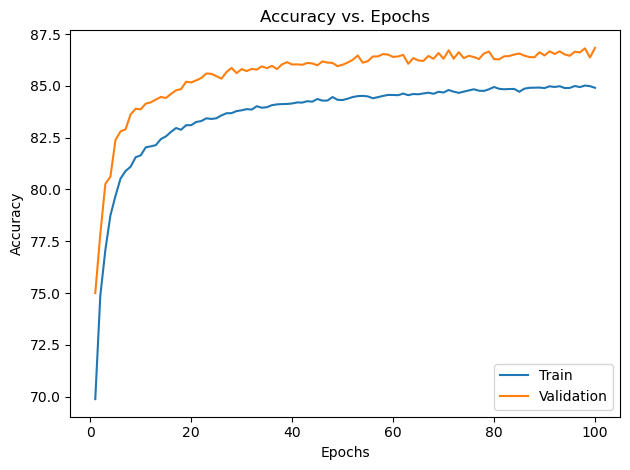

In [16]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:997: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/gpfs/alpine1/scratch/mlippincott@xsede.org/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:998: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


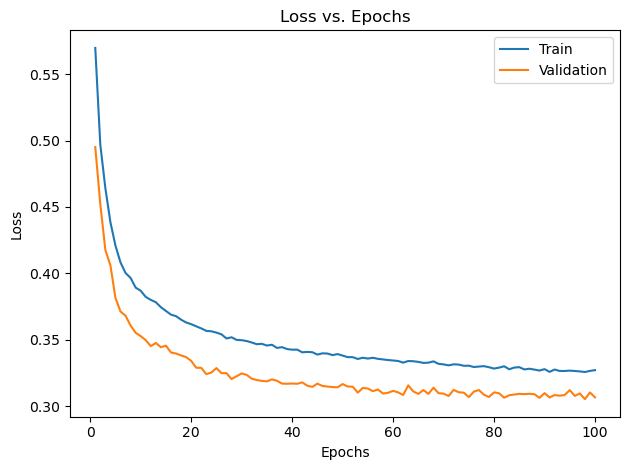

In [17]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

In [18]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


In [19]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91    149884
           1       0.87      0.80      0.84     87993

    accuracy                           0.88    237877
   macro avg       0.88      0.87      0.87    237877
weighted avg       0.88      0.88      0.88    237877



In [20]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [21]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


In [22]:
mlp_params.SHUFFLE

False

In [23]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_validation",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18736
           1       0.85      0.79      0.82     10999

    accuracy                           0.87     29735
   macro avg       0.86      0.85      0.86     29735
weighted avg       0.87      0.87      0.87     29735



In [24]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [25]:
mlp_params.MODEL_NAME

'DMSO_0.025_vs_Thapsigargin_1'

In [26]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_Thapsigargin_1


              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18736
           1       0.85      0.78      0.81     10999

    accuracy                           0.87     29735
   macro avg       0.86      0.85      0.86     29735
weighted avg       0.87      0.87      0.87     29735



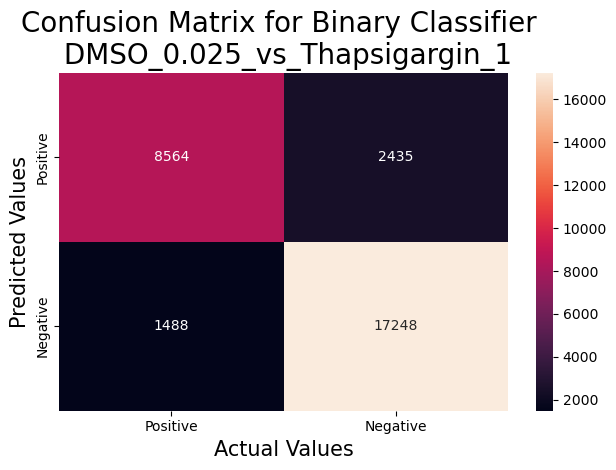

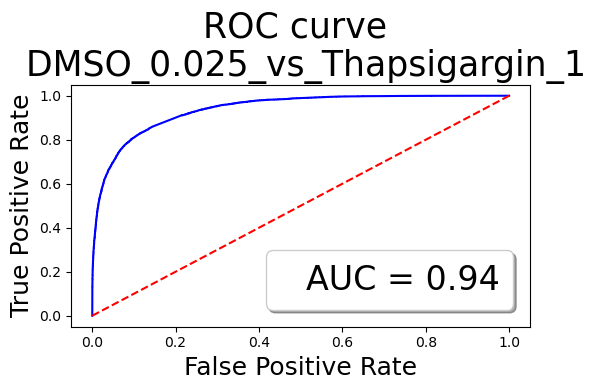

In [27]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [28]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_test",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18736
           1       0.85      0.78      0.81     10999

    accuracy                           0.87     29735
   macro avg       0.86      0.85      0.86     29735
weighted avg       0.87      0.87      0.87     29735



In [29]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

## Test the hold out wells

In [30]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [31]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

DMSO_0.025_vs_Thapsigargin_1


              precision    recall  f1-score   support

           0       0.77      0.82      0.79     27774
           1       0.86      0.82      0.84     38465

    accuracy                           0.82     66239
   macro avg       0.82      0.82      0.82     66239
weighted avg       0.82      0.82      0.82     66239



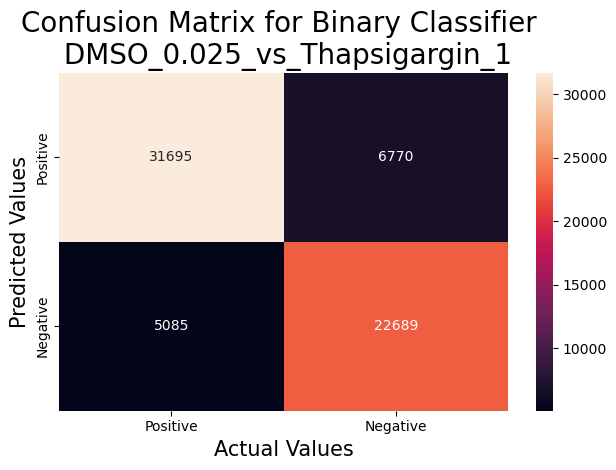

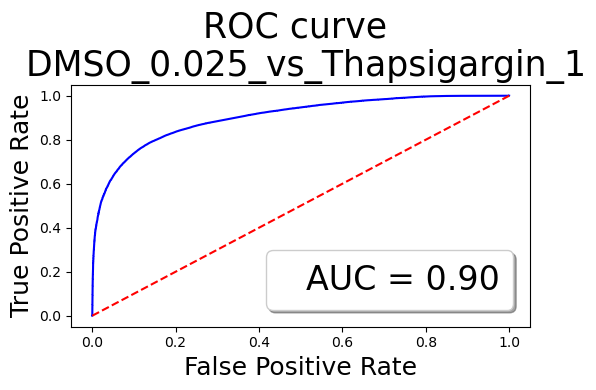

In [32]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [33]:
stats, recall, precision, f1, precision_, recall_, threshold_ = output_stats(
    y_pred_list,
    df_values_Y,
    mlp_params,
    y_pred_prob_list,
    test_name=f"{mlp_params.MODEL_NAME}_hold_out",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

              precision    recall  f1-score   support

           0       0.77      0.82      0.79     27774
           1       0.86      0.82      0.84     38465

    accuracy                           0.82     66239
   macro avg       0.82      0.82      0.82     66239
weighted avg       0.82      0.82      0.82     66239



In [34]:
threshold_ = np.append(threshold_, None)
stats_df = pd.DataFrame(
    {
        "PR_Threshold": threshold_,
        "Precision": precision_,
        "Recall": recall_,
    }
)

stats_df["treatments_tested"] = (
    mlp_params.CONTROL_NAME + " vs. " + mlp_params.TREATMENT_NAME
)
stats_df["model"] = mlp_params.MODEL_NAME
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

In [35]:
model_stats_df

,treatments_tested,model,group,shuffled_data,PR_Threshold,Precision,Recall
0,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.369910,1.000000
1,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370082,1.000000
2,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370084,1.000000
3,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370085,1.000000
4,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,train,False,0.0,0.370087,1.000000
...,...,...,...,...,...,...,...
63158,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999954,0.571429,0.000104
63159,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.99999,0.500000,0.000078
63160,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,0.999993,0.600000,0.000078
63161,DMSO_0.100_DMSO_0.025 vs. Thapsigargin_1.000_D...,DMSO_0.025_vs_Thapsigargin_1,holdout,False,1.0,0.500000,0.000052


In [36]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)